In [3]:
import pandas as pd

df = pd.read_csv('/Users/adminsha/Downloads/ab_test_data.csv')
df.head()

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0


In [7]:
a_data = pd.DataFrame(df)
result = df.groupby('test_group').agg(
    user_count=('user_id', 'count'),
    conversions=('conversion', 'sum'),
    conversion_rate=('conversion', 'mean')
).reset_index()
result['conversion_rate'] = result['conversion_rate'] * 100
print(result)

  test_group  user_count  conversions  conversion_rate
0          a       10013          611         6.102067
1          b        9985          889         8.903355


In [8]:
b_data = pd.DataFrame(data = {'test_group': ['a']*10013 + ['b']*9985,
                             'conversion': [1]*611 + [0]*(10013-611) + [1]*889 + [0]*(9985-889)})
b_data.groupby('test_group').describe()

conversion                                             
                count      mean       std  min  25%  50%  75%  max
test_group                                                        
a             10013.0  0.061021  0.239380  0.0  0.0  0.0  0.0  1.0
b              9985.0  0.089034  0.284806  0.0  0.0  0.0  0.0  1.0

In [10]:
##Нуль-гіпотеза: середня конверсія в групі А та групі Б не відрізняється

from scipy import stats

alpha = 0.05

statistic, pvalue = stats.ttest_ind(b_data[b_data['test_group']=='b']['conversion'],
                                   b_data[b_data['test_group']=='a']['conversion'],
                                   alternative = 'less')

print(f't-statistic:{round(statistic, 2)}, p-value:{round(pvalue, 2)}')

if pvalue < alpha:
    print('The difference is statistically sagnificant, null hypotesis is rejected')
else: print('The difference is insagnificant, null hypotesis cannot be rejected')


##Різниця статистично незначна, а отже середня конверсія в групі А та групі Б рівна.

t-statistic:7.53, p-value:1.0
The difference is insagnificant, null hypotesis cannot be rejected


In [11]:
##Нуль-гіпотеза: конверсія не залежить від групи, в якій вона знаходиться.

from scipy import stats

alpha = 0.05

observed = pd.crosstab(b_data['test_group'].values, b_data['conversion'].values)
statistic, pvalue, dof, expected_values = stats.chi2_contingency(observed)

print(f't-statistic: {round(statistic, 2)}, p-value: {round(pvalue, 2)}')

if pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')
    
##Відхиляємо нуль-гіпотезу, оскільки конверсія залежить від групи. 

t-statistic: 56.14, p-value: 0.0
The difference is statistically significant, Null Hypothesis is rejected.


In [13]:
##Нульова гіпотеза: дані рандомно обрані з одного розподілу.

from scipy import stats

def statistic(x, y):
    return stats.ttest_ind(x, y).statistic

alpha = 0.05
    
x = df[b_data['test_group'] == 'a']['conversion']
y = df[b_data['test_group'] == 'b']['conversion']

results = stats.permutation_test((x, y), statistic, n_resamples=9999)

print(f'statistic: {round(results.statistic, 2)}, p-value: {round(results.pvalue, 2)}')

if results.pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')
    
##Не відкидаємо нуль-гіпотезу, дані належать до одного розподілу.

statistic: -1.24, p-value: 0.23
The difference is insignificant, Null Hypothesis cannot rejected.


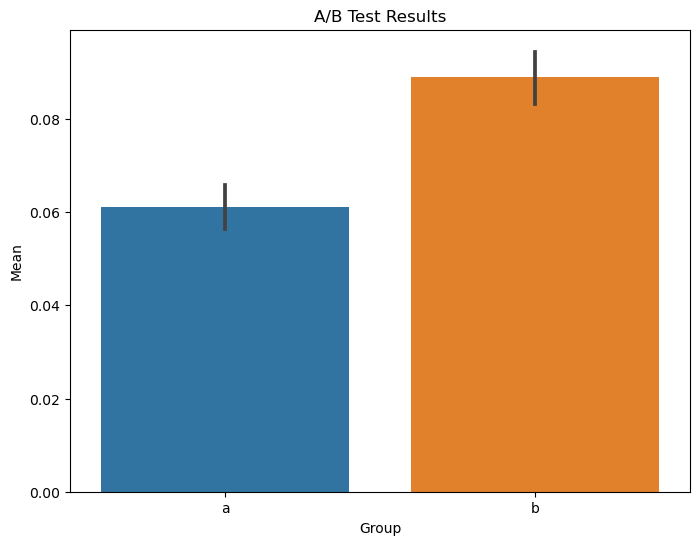

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=b_data['test_group'], 
            y=b_data['conversion'], 
            errorbar=('ci', 95))

plt.title('A/B Test Results')
plt.xlabel('Group')
plt.ylabel('Mean')

plt.show()

##Середня конверсія групи б незначно перевищує середню конаерсію групи а.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     19998 non-null  object
 1   timestamp   19998 non-null  object
 2   test_group  19998 non-null  object
 3   conversion  19998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


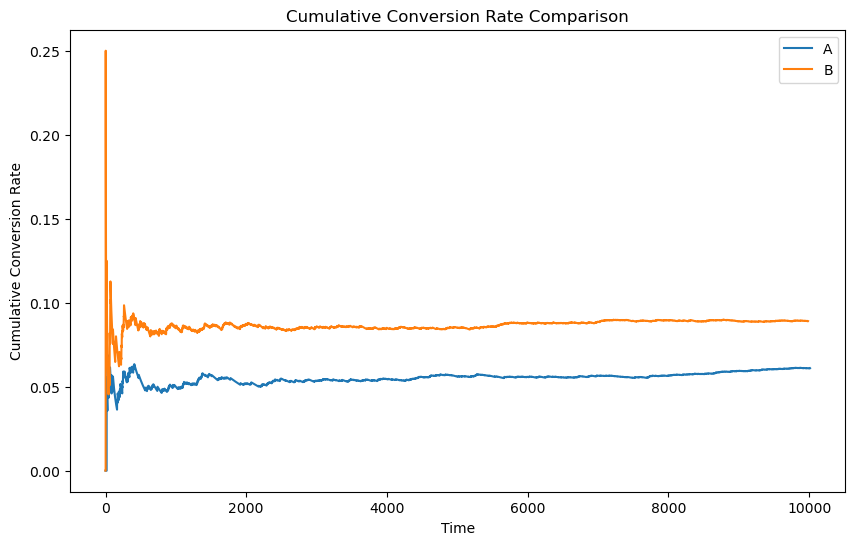

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

test_data = b_data.sample(frac=1).reset_index(drop=True)

cumulative_metric_a = test_data[test_data['test_group'] == 'a']['conversion'].expanding().mean().reset_index(drop=True)
cumulative_metric_b = test_data[test_data['test_group'] == 'b']['conversion'].expanding().mean().reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_metric_a, label='A')
plt.plot(cumulative_metric_b, label='B')

plt.title('Cumulative Сonversion Rate Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Сonversion Rate')

plt.legend()
plt.show()